In [1]:
# Import packages
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xlsxwriter
import numpy as np


In [2]:
'Simulation Parameters'

dT = 30                # number of seconds each time step is

# Temperature Setpoints
T_cab_set = 23         # [C] Setpoint temperature for vehicle cabin (per ASHRAE) 
T_bat_set = 25         # [C] setpoint temperature for vehicle battery 
T_cab_plus = 3         # [C] Range optimal temperature for vehicle cabin
T_bat_plus = 10        # [C] Range optimal temperature for vehicle battery

# Pull Down Times
t_pd_cabin_max = 600   # [seconds] Time to get to the optimal temperature in the worst condition possible
t_pd_bat_max = 600     # [seconds] Time to get to the optimal temperature in the worst condition possible

AC_max_cap = 6121.5*dT         # W - Worst scenario: car is parked outside getting direct radiation. The solar radiation
                               # is estimated to be 800 W/m2 and the ambient temperature of 40ºC (maximum in Berkeley has 
                               # been 42ºC). From article "Maximum vehicle cabin temperatures under different meteorological 
                               # conditions", Tcabin = 0.036 * SR + 1.02 * T_amb + 8.8 = 78.4ºC reached in the cabin. The car
                               # is parked (0 kmh). 5 people in the car. The cooling for the battery is added as an extra 30%
                               # as professor suggested.

In [3]:
'''
Constants
'''
g = 9.81

#vehicle properties
mass_veh = 1610           #[kg], vehicle mass
area_front = 2.22         #[m2], vehicle frontal area
P_amb = 101900            #ambient pressure (atmospheric) [Pa]
rho_amb = 1.202           #[kg/m3], ambient air density
hum_amb = 0.72            #ambient relative humidity [%]
hum_set = 0.50            #relative humidity of cabin [%]
cp_amb = 1000             # [J/kgK]

cd = 0.24                 #[--], vehicle drag coefficient
crr = 0.02                #[--], tire rolling resistance

# Surfaces: glass, doors, roof
Area_g = 3.5              #m2
Thick_g = 0.004           #m
TConduc_g = 0.96          #W/m/K
SpeHeat_g = 840           #J/kg/K

Area_d = 4                #m2
Thick_d = 0.06            #m
TConduc_d = 0.08          #W/m/K
SpeHeat_d = 500           #J/kg/K

Area_r = 2                #m2
Thick_r = 0.04            #m
TConduc_r = 0.08          #W/m/K
SpeHeat_r = 500           #J/kg/K


# Battery characteristics
mass_bat = 345            # [kg], battery mass
eta_bat = 0.90            # [], battery discharge efficiency
cp_bat = 900              # [J/kgK], specific heat capacity of battery pack

# cabin properties
m_vent = 0.1              # [m3/s] ventialtion mass flow rate 
V_cabin = 3.1715          # [m3], internal vehicle volume
P_cabin = P_amb       
rho_cabin = rho_amb
mass_cabin = 200          # [kg], Interior mass (dashboard, seats, steering wheel, sidepannels...)
cp_cabin = 1500           # [J/kgK] Specific heat capacity of the interior of the car
V_int = 0.                # [km/h] Velocity of air inside the vehicle
DTM = 243583              # [J/K]   (m*cp     200 kg * 1000 J/kgK)

# Passenger characteristics
WeightAVE = 70            # [kg]
HeightAVE = 1.7           # [m]
DriverHR = 85             # [W/m2]
SittingHR = 55            # [W/m2]

cp_air = 1.02*1000      # J / kg K

# Refrigeration
eta_comp = 0.85    
Ref_quality = 0.8

# Saturation Enthalpy for R134a
# Temperature (C), hf, hg, hfg [kJ/kg] - (Might need to add colder temperatures (T < 0C))
hfg_ref = [[0, 200.0, 398.8, 198.8],
           [1, 201.3, 399.4, 198.0],
           [2, 202.7, 400.0, 197.3],
           [3, 204.0, 400.5, 196.5],
           [4, 205.4, 401.1, 195.7],
           [5, 206.8, 401.7, 194.9],
           [6, 208.1, 402.3, 194.2],
           [7, 209.5, 402.8, 193.4],
           [8, 210.8, 403.4, 192.6],
           [9, 212.2, 404.0, 191.8],
           [10, 213.6, 404.5, 190.9],
           [11, 215.0, 405.1, 190.1],
           [12, 216.4, 405.6, 189.3],
           [13, 217.7, 406.2, 188.5],
           [14, 219.1, 406.8, 187.6],
           [15, 220.5, 407.3, 186.8],
           [16, 221.9, 407.8, 185.9],
           [17, 223.3, 408.4, 185.1],
           [18, 224.7, 408.9, 184.2],
           [19, 226.1, 409.5, 183.3],
           [20, 227.5, 410.0, 182.5],
           [21, 228.9, 410.5, 181.6],
           [22, 230.4, 411.0, 180.7],
           [23, 231.8, 411.6, 179.8],
           [24, 233.2, 412.1, 178.9],
           [25, 234.6, 412.6, 178.0],
           [26, 236.1, 413.1, 177.0],
           [27, 237.5, 413.6, 176.1],
           [28, 238.9, 414.1, 175.2],
           [29, 240.4, 414.6, 174.2],
           [30, 241.8, 415.1, 173.3],
           [31, 243.3, 415.6, 172.3],
           [32, 244.8, 416.1, 171.3],
           [33, 246.2, 416.6, 170.3],
           [34, 247.7, 417.0, 169.3],
           [35, 249.2, 417.5, 168.3],
           [36, 250.6, 418.0, 167.3],
           [37, 252.1, 418.4, 166.3],
           [38, 253.6, 418.9, 165.3],
           [39, 255.1, 419.3, 164.2],
           [40, 256.6, 419.8, 163.2],
           [41, 258.1, 420.2, 162.1],
           [42, 259.6, 420.6, 161.0],
           [43, 261.1, 421.1, 159.9],
           [44, 262.7, 421.5, 158.8],
           [45, 264.2, 421.9, 157.7],
           [46, 265.7, 422.3, 156.6],
           [47, 267.3, 422.7, 155.4],
           [48, 268.8, 423.1, 154.3],
           [49, 270.4, 423.5, 153.1],
           [50, 271.9, 423.8, 151.9],
           [51, 273.5, 424.2, 150.7],
           [52, 275.1, 424.6, 149.5],
           [53, 276.6, 424.9, 148.3],
           [54, 278.2, 425.3, 147.0],
           [55, 279.8, 425.6, 145.8],
           [56, 281.4, 425.9, 144.5],
           [57, 283.0, 426.2, 143.2],
           [58, 284.6, 426.5, 141.9],
           [59, 286.3, 426.8, 140.5],
           [60, 287.9, 427.1, 139.2],
           [61, 289.5, 427.4, 137.8],
           [62, 291.2, 427.6, 136.4],
           [63, 292.9, 427.9, 135.0],
           [64, 294.5, 428.1, 133.6],
           [65, 296.2, 428.3, 132.1],
           [66, 297.9, 428.5, 130.6],
           [67, 299.6, 428.7, 129.1],
           [68, 301.3, 428.8, 127.5],
           [69, 303.0, 429.0, 126.0],
           [70, 304.8, 429.1, 124.4]]
           
hfg_ref = np.array(hfg_ref)     

In [930]:
'''Create Scenario'''

'Initialize: Input Array, xarray'
# size of xdata array will depend on how many time steps we want to use***
xdata = []

#Input Data:Nº passengers, Vehicle velocity km/h, Grade %, Ambient T (ºC), Cabin T (ºC), Battery T (ºC),AC
 
for i in range(5): 
    if i == 0: p = 1
    elif i ==1: p = 2
    elif i ==2: p = 3
    elif i ==3: p = 4
    else: p = 5
    for j in range(7):
        if j == 0: v = 0
        elif j == 1: v = 20
        elif j == 2: v = 40
        elif j == 3: v = 60
        elif j == 4: v = 80
        elif j == 5: v = 100
        else: v = 120
        for k in range(5): 
            gr = 3*k
            for l in range(5):
                if l == 0:  Ta = 30
                elif l==1:  Ta = 35
                elif l==2:  Ta = 40
                elif l==3:  Ta = 42.5
                else: Ta = 46
                for m in range(28):
                    if  m ==0: Tc = 23
                    elif m==1: Tc = 23.05
                    elif m==2: Tc = 23.1
                    elif m==3: Tc = 23.15
                    elif m==4: Tc = 23.2
                    elif m==5: Tc = 23.25
                    elif m==6: Tc = 23.3
                    elif m==7: Tc = 23.35
                    elif m==8: Tc = 23.4
                    elif m==9: Tc = 23.45
                    elif m==10: Tc = 23.5
                    elif m==11: Tc = 23.75
                    elif m==12: Tc = 24.25
                    elif m==13: Tc = 24.75
                    elif m==14: Tc = 25.5
                    elif m==15: Tc = 25.9
                    elif m==16: Tc = 26.1
                    elif m==17: Tc = 27.5
                    elif m==18: Tc = 29
                    elif m==19: Tc = 32.5
                    elif m==20: Tc = 37
                    elif m==21: Tc = 41
                    elif m==22: Tc = 45
                    elif m==23: Tc = 48
                    elif m==24: Tc = 52
                    elif m==25: Tc = 22.5
                    elif m==26: Tc = 22
                    else: Tc = 55
                    for n in range(26):
                        if  n ==0: Tb = 25
                        elif n==1: Tb = 25.05
                        elif n==2: Tb = 25.1
                        elif n==3: Tb = 25.15
                        elif n==4: Tb = 25.2
                        elif n==5: Tb = 25.25
                        elif n==6: Tb = 25.3
                        elif n==7: Tb = 25.35
                        elif n==8: Tb = 25.4
                        elif n==9: Tb = 25.45
                        elif n==10: Tb = 25.5
                        elif n==11: Tb = 26
                        elif n==12: Tb = 28
                        elif n==13: Tb = 29.9
                        elif n==14: Tb = 30.1
                        elif n==15: Tb = 31
                        elif n==16: Tb = 33
                        elif n==17: Tb = 34
                        elif n==18: Tb = 34.9
                        elif n==19: Tb = 35.1
                        elif n==20: Tb = 36
                        elif n==21: Tb = 37.5
                        elif n==22: Tb = 39
                        elif n==23: Tb = 24.5
                        elif n==24: Tb = 24
                        else: Tb = 41
                        xdata.append([p,v,gr,Ta,Tc,Tb])
                        
xarray= np.array(xdata)

xarray = np.zeros((len(xdata), 6))  
for i in range(len(xarray)):
    for j in range(6): 
        xarray[i][j] = xdata[i][j]           

'Initialize: Heat Array, qarray'
qarray = np.zeros((len(xarray), 6))

'Initialize: Output Array, yarray'
yarray = np.zeros((len(xarray), 9))

'''with np.printoptions(threshold=np.inf):
  np.set_printoptions(precision=3, suppress = True)
  print(xarray)
'''

'with np.printoptions(threshold=np.inf):\n  np.set_printoptions(precision=3, suppress = True)\n  print(xarray)\n'

In [931]:

for i in range(len(xarray)):
      
    #######################################################################################################################
    ##############################################  CABIN   HEAT  LOAD  ###################################################
    #######################################################################################################################

    '''Metabolic Load'''
    # From ISO 8996: Driver 85W/m2 and sitting passenger 55 W/m2
    # Estimation of surface area (Dubois Area)
    DuboisArea = 0.202*(WeightAVE**0.425)*HeightAVE**0.725

    #Metabolic Load
    Q_metabolic = DuboisArea*(DriverHR + xarray[i][0]*SittingHR) * dT #W

    
    '''Ambient Load'''
    # Convective heat transfer coefficient
    h_int = 0.6 + 6.64*np.sqrt(V_int*1000/3600) # W/m2K
    h_out = 0.6 + 6.64*np.sqrt(xarray[i][1]*1000/3600) # W/m2K

    # Overall heat transfer coefficient
    U_g = 1/(1/h_int + Thick_g/TConduc_g + 1/h_out)
    U_d = 1/(1/h_int + Thick_d/TConduc_d + 1/h_out)
    U_r = 1/(1/h_int + Thick_r/TConduc_r + 1/h_out)

    # To calculate the temperature of the surfaces Qcond = Qconv
    T_g = (h_out*xarray[i][3]+TConduc_g*xarray[i][4]/Thick_g)/(h_out+TConduc_g/Thick_g)
    T_d = (h_out*xarray[i][3]+TConduc_d*xarray[i][4]/Thick_d)/(h_out+TConduc_d/Thick_d)
    T_r = (h_out*xarray[i][3]+TConduc_r*xarray[i][4]/Thick_r)/(h_out+TConduc_r/Thick_r)

    #print(T_g,T_d,T_r)
    # The heat realeases to the cabin is
    Q_g = Area_g*U_g*(T_g-xarray[i][4]) * dT
    Q_d = Area_d*U_d*(T_d-xarray[i][4]) * dT
    Q_r = Area_r*U_r*(T_r-xarray[i][4]) * dT

    #ambient load
    Q_ambient = Q_g + Q_d + Q_r 
        
    
    '''Ventilation Load'''
    # An easy way to calculate the fresh air thermal load is following the article "Electric Vehicle Battery Thermal
    # and Cabin Climate Management Based on Model Predictive Control"
    
    # As the CO2 linearly increases over time, a minimum flow of fresh air should be supplied into the cabin to maintain
    # the passengers confort
    
    Q_ventilation = 0.12*0.186*1000*(xarray[i][3]-xarray[i][4]) * dT
    
    
    '''Radiation load'''
    # Radiation should be in units [W/m2] not [W]

    # Direct = Part of the incident radiation that directly strikes a surface 
    # of the vehicle
    Q_direct = 1000 * dT # W

    # Diffuse radiation is the part of solar radiation which results from indirect
    # radiation of daylight on the surface
    # This value can be modified...
    Q_diffuse = 190 * dT # W

    # Reflected radiation refers to the part of radiation heat gain that is reflected 
    # from the ground and strikes the body surface of the vehicle. 
    # This value can be modified...
    Q_reflected = 0 * dT # W

    # Radiation Load
    Q_radiation = Q_direct + Q_diffuse + Q_reflected


    '''Total Cabin Heat'''
    Q_cabin = Q_metabolic + Q_ambient + Q_ventilation + Q_radiation
        
    qarray[i][0]=Q_cabin

    
    #######################################################################################################################
    ##############################################  BATTERY HEAT GAIN   ###################################################
    #######################################################################################################################
    
    slope = np.arctan(xarray[i][2]/100)
    slope_d = slope*360/(2*np.pi)
    mass_veh_total = mass_veh + xarray[i][0]*WeightAVE


    ''' Heat Gain due to driving'''
    # Forces on vehicle
    f_drag = 0.5*rho_amb*(xarray[i][1]/3.6)**2*cd*area_front
    f_rolling = crr*mass_veh_total*g*np.cos(slope)
    f_gravity = mass_veh_total*g*np.sin(slope)
    f_total = f_drag+f_rolling+f_gravity

    # Power of vehicle
    p_drive = f_total*(xarray[i][1]/3.6)*10**-3          #kW

    # Heat gain of battery, due to driving
    Q_bat_drive = p_drive*(1-eta_bat)*1000*dT          # [W]
    
    
    '''Heat Gain due to compressor power'''
    # AC is always on
    W_comp = 4                     # [kW]  (compressor power is constant for now...)

    Q_bat_comp = (1 - eta_comp)*W_comp*1000*dT
    
    '''Auxiliary Power - System Electronics'''
    # Except for the steering power, air conditioning and window defroster, the rest auxiliary consumption is covered by 
    # the auxiliary battery. As depicted in https://onlinelibrary.wiley.com/doi/epdf/10.1002/er.5700 only the driving control
    # and the energy management system are taken into consideration (Total = 300W)
    p_aux = 500 # W
    Q_bat_aux = (1 - eta_bat)*p_aux*dT
    
    '''Total Battery Heat'''
    Q_bat = Q_bat_drive + Q_bat_comp + Q_bat_aux
        
    qarray[i][1] = Q_bat
    
    
    #######################################################################################################################
    ##############################################  REFRIGERATION   ###################################################
    #######################################################################################################################
    
    'Evaporator, Condenser conditions'
    T_ref_evap = 4                        #[C], 4 deg above freezing     (should this value be static?)
    T_ref_cond = xarray[i][3] + 10        #[C], 10 deg above ambient temperature
    
    # Find latent heat from evaporator temperature
    hfg_ref_cool = (hfg_ref[int(hfg_ref[np.where(hfg_ref == round(T_ref_evap,0))])][3])*Ref_quality*1000 # [J/kg]

    # calculate the max mass flow rate
    Mass_max_cap = (AC_max_cap / hfg_ref_cool)/dT

    'Pull-Down Time'
    t_pd_cabin = (qarray[i][0] / AC_max_cap) * t_pd_cabin_max / dT
    t_pd_bat = (qarray[i][1] / AC_max_cap) * t_pd_bat_max / dT
    
    
    'Required Refrigeration Load'

    # Cabin
    qarray[i][2] = (-1*qarray[i][0] - ((rho_cabin * V_cabin * cp_air + DTM) * (xarray[i][4] - T_cab_set))/t_pd_cabin) 
    # Battery 
    qarray[i][3] = (-1*qarray[i][1] - (mass_bat * cp_bat * (xarray[i][5] - T_bat_set))/t_pd_bat) 
    
    #######################################################################################################################
    ##############################################  REFRIGERATION DECISIONS   #############################################
    #######################################################################################################################

    'Total Refrigeration Load'
    Q_total = qarray[i][2] + qarray[i][3]
    y = qarray[i][2] / Q_total
    
    # We are always cooling
    # if (xarray[i][4]>T_cab_set) or (xarray[i][5]>T_bat_set):
    if (xarray[i][5] >= T_bat_set + T_bat_plus) and (xarray[i][4] < T_cab_set + T_cab_plus):
        qarray[i][4] = 0
        qarray[i][5] = -AC_max_cap
    elif  (xarray[i][4] >= T_cab_set + T_cab_plus) and (xarray[i][5] < T_bat_set + T_bat_plus):
        qarray[i][4] = -AC_max_cap
        qarray[i][5] = 0
    elif (xarray[i][5] >= T_bat_set + T_bat_plus) and (xarray[i][4] >= T_cab_set + T_cab_plus):
        qarray[i][4] = -y*AC_max_cap     # '-' is to indicate cooling
        qarray[i][5] = -(1-y)*AC_max_cap  # '-' is to indicate cooling
    elif (xarray[i][5] < T_bat_set + T_bat_plus) and (xarray[i][4] < T_cab_set + T_cab_plus):
        if np.abs(Q_total) > AC_max_cap:
            qarray[i][4] = -y*AC_max_cap     # '-' is to indicate cooling
            qarray[i][5] = -(1-y)*AC_max_cap  # '-' is to indicate cooling
        else:
            qarray[i][4] = qarray[i][2]      # '-' is to indicate cooling
            qarray[i][5] = qarray[i][3]   # '-' is to indicate cooling     
            
    if (xarray[i][4]<T_cab_set):
        qarray[i][4] = 0
    if (xarray[i][5]<T_bat_set):
        qarray[i][5] = 0
      
    # calculate new mass fraction
    yarray[i][0] = 0

    'Mass Flow Rate'
    # Cabin Evaporator
    yarray[i][3] = abs(qarray[i][4]/hfg_ref_cool)/dT
    yarray[i][5] = (yarray[i][3] / Mass_max_cap)*100
    # Battery Chiller
    yarray[i][4] = abs(qarray[i][5]/hfg_ref_cool)/dT
    yarray[i][6] = (yarray[i][4] / Mass_max_cap)*100
    # Total Flow Rate
    yarray[i][7] = yarray[i][3] + yarray[i][4]
    
        
    #######################################################################################################################
    ###############################################   NEW TIME STEP   ####################################################
    #######################################################################################################################
    
    'Update Temperatures for Next Time Step'
    # Cabin Temperature
    deltaT_cabin = ((qarray[i][0] + qarray[i][4]) / (rho_cabin * V_cabin * cp_air + DTM))
    yarray[i][1] = xarray[i][4] + deltaT_cabin

    # Battery Temperature
    deltaT_bat = (qarray[i][1] + qarray[i][5]) / (mass_bat * cp_bat)
    yarray[i][2] = xarray[i][5] + deltaT_bat
    
    # Percentage of AC System use
    yarray[i][8] = np.abs((qarray[i][4]+qarray[i][5]))/np.abs(AC_max_cap)*100

len(xarray)


637000

In [932]:
print(xarray[0]) #["No. Passengers", "Velocity", "Grade", "Ambient Temp", "Cabin Temp","Battery Temp"]
print(yarray[0]) #["Mode", "Cabin Temp", "Battery Temp","mdot Cabin","mdot battery", "%cabin", "%battery", "mdot total", "%total"]

[ 1.  0.  0. 30. 23. 25.]
[0.00000000e+00 2.30000000e+01 2.50000000e+01 1.02324788e-02
 4.15176290e-03 2.61700053e+01 1.06183125e+01 1.43842417e-02
 3.67883178e+01]


In [4]:
import pandas as pd
import xlsxwriter
import numpy as np


In [934]:
#Create database for inputs and outputs
df_inputs = pd.DataFrame(xarray, columns=["No. Passengers", "Velocity",\
                                          "Grade", "Ambient Temp", "Cabin Temp","Battery Temp"])

df_outputs = pd.DataFrame(yarray, columns=["Mode", "Cabin Temp", "Battery Temp",\
                                           "mdot Cabin","mdot battery", "%cabin", "%battery", "mdot total", "%total"])
                                     
#Create excel spreadsheets for input and output databases
df_inputs.to_excel('inputs_DATA.xlsx', sheet_name='Inputs',engine='xlsxwriter')  
df_outputs.to_excel('outputs_DATA.xlsx', sheet_name='Outputs',engine='xlsxwriter')  


In [14]:
#Read in data from databases
df_inputs = pd.read_excel('inputs_DATA.xlsx').drop(columns="Unnamed: 0")
df_outputs = pd.read_excel('outputs_DATA.xlsx').drop(columns="Unnamed: 0")

df_outputs = df_outputs.drop(columns=["Mode", "Cabin Temp", "Battery Temp", "mdot Cabin","mdot battery","mdot total","%total"])

In [15]:
#Convert datafrane to arrays
xarray = df_inputs.to_numpy()
yarray = df_outputs.to_numpy()

In [16]:
# PCA Analysis

xDataMean = np.mean(xarray,0)
xDataSD = np.std(xarray,0)

# Normalize each value
#xArrayNorm = xarray*0
xArrayNorm = np.zeros((len(xarray), 6)) 
for i in range(len(xarray)):
    xArrayNorm[i][0] = (xarray[i][0]-xDataMean[0])/xDataSD[0]
    xArrayNorm[i][1] = (xarray[i][1]-xDataMean[1])/xDataSD[1]
    xArrayNorm[i][2] = (xarray[i][2]-xDataMean[2])/xDataSD[2]
    xArrayNorm[i][3] = (xarray[i][3]-xDataMean[3])/xDataSD[3]
    xArrayNorm[i][4] = (xarray[i][4]-xDataMean[4])/xDataSD[4]
    xArrayNorm[i][5] = (xarray[i][5]-xDataMean[5])/xDataSD[5]

X = xArrayNorm
C = np.cov(X.T)
print(C)
from numpy import linalg as LA
w,v = LA.eig(C)
print(w)


[[ 1.00000157e+00  1.17791885e-17  0.00000000e+00 -1.78472553e-18
   4.81875893e-18 -1.11545346e-20]
 [ 1.17791885e-17  1.00000157e+00  2.46292123e-17 -1.71333651e-17
   5.08646776e-18  8.36590092e-21]
 [ 0.00000000e+00  2.46292123e-17  1.00000157e+00 -1.53129450e-16
   5.66650355e-17 -1.70385515e-18]
 [-1.78472553e-18 -1.71333651e-17 -1.53129450e-16  1.00000157e+00
  -5.63973267e-17  7.92529680e-18]
 [ 4.81875893e-18  5.08646776e-18  5.66650355e-17 -5.63973267e-17
   1.00000157e+00  8.53809904e-18]
 [-1.11545346e-20  8.36590092e-21 -1.70385515e-18  7.92529680e-18
   8.53809904e-18  1.00000157e+00]]
[1.00000157 1.00000157 1.00000157 1.00000157 1.00000157 1.00000157]


In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X = df_inputs.values
scaler.fit(X)
X_scaled = scaler.transform(X)

PCA_95 = PCA(n_components= 0.98)
PCA_95.fit(X_scaled)
X_PCA_95 = PCA_95.transform(X_scaled)

print(PCA_95.explained_variance_ratio_*100)


[16.66666667 16.66666667 16.66666667 16.66666667 16.66666667 16.66666667]


In [18]:
xDataMedian = np.median(xarray, 0)
yDataMedian = np.median(yarray,0)

xDataNorm = np.zeros((len(xarray),6))

for i in  range(len(xarray)):
    xDataNorm[i][0] = xarray[i][0]/xDataMedian[0]
    xDataNorm[i][1] = xarray[i][1]/xDataMedian[1]
    xDataNorm[i][2] = xarray[i][2]/xDataMedian[2]
    xDataNorm[i][3] = xarray[i][3]/xDataMedian[3]
    xDataNorm[i][4] = xarray[i][4]/xDataMedian[4]
    xDataNorm[i][5] = xarray[i][5]/xDataMedian[5]

yDataNorm = np.zeros((len(yarray),2))

for i in range(len(yarray)):
    yDataNorm[i][0] = yarray[i][0]/100 #/yDataMedian[2] - Dont divide it by yDataMedian because the median is either 100 or 0
    yDataNorm[i][1] = yarray[i][1]/100 #/yDataMedian[3]

print(yDataNorm)

[[0.26170005 0.10618313]
 [0.26170005 0.14599082]
 [0.26170005 0.18579851]
 ...
 [1.         0.        ]
 [1.         0.        ]
 [0.76963931 0.23036069]]


In [206]:
import keras 
from keras import backend as K
from keras.models import Sequential
import numpy as np
import keras.backend as kb

In [218]:
from sklearn.model_selection import train_test_split
x_train, x_validation, y_train, y_validation = train_test_split(xDataNorm, yDataNorm, test_size=1/4,shuffle=True)


In [219]:
initializer = keras.initializers.RandomUniform(minval= -1, maxval=1)

In [209]:
import tensorflow as tf
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout,Concatenate
from kerastuner.engine.hyperparameters import HyperParameters
from kerastuner.tuners import BayesianOptimization
import keras_tuner as kt

K.relu(x_train,max_value=1)

#Model optimisation 
LOG_DIR = f"{int(time.time())}"
'An argument hp for defining the hyperparameters while building the model.'
def build_model(hp):
    model = keras.Sequential()
    model.add(Dense(hp.Int('Dense_0',10,100,10), activation=K.elu, input_shape=[6],  kernel_initializer=initializer))
    model.add(Dropout(hp.Float('Dropout_0',0.20,0.5,0.05)))
    
    'Number of dense layers: between 1 to 3'
    for i in range (hp.Int('Num Dense',1,3,1)): 
        'Number of neurons per layer: between 10 to 100'
        model.add(Dense(hp.Int(f"Dense_{i+1}",10,100,10),\
                        activation=hp.Choice(f"Activation_{i+1}", ["relu", "elu", "tanh"]),\
                        kernel_initializer=initializer))
        'Dropout value: between 20 to 50%'
        model.add(Dropout(hp.Float(f"Dropout_{i+1}",0.20,0.50,0.05)))
        
    'layers.Dense(units=hp.Int("units", min_value=32, max_value=512, step=32),activation="relu")'
    'Output Later'
    model.add(Dense(2, kernel_initializer=initializer))
    # No activation function in the last dense gives a huge difference    
    model.compile(
        optimizer= 'adam',
        loss='mae', 
        metrics=['mae'])

    return model

bayesion_opt_tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective='mae',
    #'Different trials have different hyperparameter values'
    max_trials=10,
    #'The executions within the same trial have the same hyperparameter values.'
    executions_per_trial=1,
    overwrite=False,
    directory= LOG_DIR,
    project_name="Random_Data",
)

bayesion_opt_tuner.search(x_train, y_train, epochs=10, validation_data=(x_validation, y_validation))

bayes_opt_model_best_model = bayesion_opt_tuner.get_best_models(num_models=1)
model = bayes_opt_model_best_model[0]

model.summary()
bayesion_opt_tuner.results_summary()

Trial 10 Complete [00h 02m 17s]
mae: 0.07742509990930557

Best mae So Far: 0.07094204425811768
Total elapsed time: 00h 21m 32s
INFO:tensorflow:Oracle triggered exit
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               700       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 11,002
Trainable params: 11,002
Non-trainable params: 0
___________________

In [177]:
# define neural network model

from keras import backend as K
initializer = keras.initializers.RandomUniform(minval= -1, maxval=1)


model = keras.Sequential([
    keras.layers.Dense(60, activation=K.elu, input_shape=[6],  kernel_initializer=initializer),
    keras.layers.Dropout(0.2), 
    keras.layers.Dense(80, activation=K.elu, kernel_initializer=initializer),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(40, activation=K.tanh, kernel_initializer=initializer),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(2, kernel_initializer=initializer)
  ])


In [178]:
#We’re using Adams as our optimizer here. 
#We’re compiling the mode using the model.compile function. The loss function used here 
#is mean squared error. After the compilation of the model, we’ll use the fit method with ~500 epochs.
#Number of epochs can be varied.

model.compile(loss='mae',optimizer='adam')

In [179]:
# Add a checkpoint where loss is minimum, and save that model
mc = keras.callbacks.ModelCheckpoint('best_model.SB', monitor='loss', 
                     mode='min',  verbose=1, save_best_only=True)

historyData = model.fit(x_train, y_train, epochs=50,validation_data=(x_validation, y_validation))

loss_hist = historyData.history['loss']
#The above line will return a dictionary, access it's info like this:
best_epoch = np.argmin(historyData.history['loss']) + 1
print ('best epoch = ', best_epoch)
print('smallest loss =', np.min(loss_hist))

model.save('./best_model')

Epoch 1/50
14930/14930 [==============================] - 38s 3ms/step - loss: 0.2758 - val_loss: 0.0974
Epoch 2/50
14930/14930 [==============================] - 34s 2ms/step - loss: 0.1049 - val_loss: 0.0843
Epoch 3/50
14930/14930 [==============================] - 34s 2ms/step - loss: 0.0951 - val_loss: 0.0689
Epoch 4/50
14930/14930 [==============================] - 37s 2ms/step - loss: 0.0872 - val_loss: 0.0621
Epoch 5/50
14930/14930 [==============================] - 37s 2ms/step - loss: 0.0817 - val_loss: 0.0544
Epoch 6/50
14930/14930 [==============================] - 36s 2ms/step - loss: 0.0772 - val_loss: 0.0486
Epoch 7/50
14930/14930 [==============================] - 32s 2ms/step - loss: 0.0744 - val_loss: 0.0456
Epoch 8/50
14930/14930 [==============================] - 37s 2ms/step - loss: 0.0728 - val_loss: 0.0447
Epoch 9/50
14930/14930 [==============================] - 38s 3ms/step - loss: 0.0716 - val_loss: 0.0489
Epoch 10/50
14930/14930 [==============================

In [946]:
# This line of code can be used to reconstruct the saved model.
recon_model = keras.models.load_model("best_model")


In [947]:
# Save the model to use in the future
from keras.models import model_from_json
import os

# serialize model to JSON
model_json = recon_model.to_json()
with open("recon_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
recon_model.save_weights("model.h5")
print("Saved model to disk")


Saved model to disk


In [20]:
# Load save model
# load json and create model
# Import packages
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.models import model_from_json
import os
import tensorflow as tf
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout,Concatenate
from kerastuner.engine.hyperparameters import HyperParameters
from kerastuner.tuners import BayesianOptimization
import keras_tuner as kt
import keras 
from keras import backend as K
from keras.models import Sequential
import numpy as np
import keras.backend as kb
import pandas as pd
import xlsxwriter
import numpy as np
import os

json_file = open('recon_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
recon_model = model_from_json(loaded_model_json)
# load weights into new model
recon_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
recon_model.compile(loss='mae',optimizer='adam')


Loaded model from disk


In [21]:
# TRAINING PREDICTIONS
#predicted_mdotCabin, predicted_mdotBattery = [], []
#actual_mdotCabin, actual_mdotBattery = [], []

from sklearn.model_selection import train_test_split
x_train, x_validation, y_train, y_validation = train_test_split(xDataNorm, yDataNorm, test_size=1/4,shuffle=True)

predicted_mCabin, predicted_mBattery = [], []
actual_mCabin, actual_mBattery = [], []

for i in range(30):
    predicted_mCabin.append(recon_model.predict(x_validation)[i][0]*100)
    actual_mCabin.append(y_validation[i][0]*100)
    predicted_mBattery.append(recon_model.predict(x_validation)[i][1]*100)
    actual_mBattery.append(y_validation[i][1]*100)


In [22]:
pd.DataFrame(data=(predicted_mCabin,actual_mCabin, predicted_mBattery,actual_mBattery)).transpose()

,0,1,2,3
0,27.677947,27.419145,74.383950,72.580855
1,98.720807,100.000000,0.117925,0.000000
2,14.001712,0.000000,89.176548,100.000000
3,30.129999,29.003558,72.243643,70.996442
4,55.971652,51.163781,45.334345,48.836219
5,22.854295,26.035919,78.419578,73.964081
6,36.978623,35.517360,28.224617,22.560620
7,40.882438,37.730460,41.476583,41.651406
8,43.426749,44.720700,54.313904,55.279300
9,98.720807,100.000000,0.117925,0.000000


In [237]:
# TEST - Scenario 
# Inputs
#Read in data from databases
Scenario = 4
if Scenario ==1: 
    #MAE = 2.41%
    df_inputs = pd.read_excel('inputs_Sen1.xlsx')
    df_outputs = pd.read_excel('outputs_Sen1.xlsx')
    Folder = "\Scenario1"
    SC = '\S1_'
if Scenario ==2: #I dont like it
    #MAE = 5.19%
    df_inputs = pd.read_excel('inputs_Sen2.xlsx')
    df_outputs = pd.read_excel('outputs_Sen2.xlsx')
    Folder = "\Scenario2"
    SC = '\S2_'
if Scenario ==3: 
    #MAE = 2.04%
    df_inputs = pd.read_excel('inputs_Sen3.xlsx')
    df_outputs = pd.read_excel('outputs_Sen3.xlsx')
    Folder = "\Scenario3"
    SC = '\S3_'
elif Scenario ==4: 
    #MAE = 5.06%
    df_inputs = pd.read_excel('inputs_Sen4.xlsx')
    df_outputs = pd.read_excel('outputs_Sen4.xlsx')
    Folder = "\Scenario4"
    SC = '\S4_'
elif Scenario == 5:
    # MAE = 3.46%
    df_inputs = pd.read_excel('inputs_Sen5.xlsx')
    df_outputs = pd.read_excel('outputs_Sen5.xlsx')
    Folder = "\Scenario5"
    SC = '\S5_'
elif Scenario == 6:
    # MAE = 6.97%
    df_inputs = pd.read_excel('inputs_Sen6.xlsx')
    df_outputs = pd.read_excel('outputs_Sen6.xlsx')
    Folder = "\Scenario6"
    SC = '\S6_'
elif Scenario == 7:
    # MAE = 1.67%
    df_inputs = pd.read_excel('inputs_Sen7.xlsx')
    df_outputs = pd.read_excel('outputs_Sen7.xlsx')
    Folder = "\Scenario7"
    SC = '\S7_'
elif Scenario == 8:
    # MAE = 5.57%
    df_inputs = pd.read_excel('inputs_Sen8.xlsx')
    df_outputs = pd.read_excel('outputs_Sen8.xlsx')
    Folder = "\Scenario8"
    SC = '\S8_'

path = r"C:\Users\danis\Documents\MEng\Capstone Project\Results"
path = path + Folder


In [238]:
print(path)

C:\Users\danis\Documents\MEng\Capstone Project\Results\Scenario4


In [239]:
# ML model prediction

predicted_mCabin, predicted_mBattery = [], []
actual_mCabin, actual_mBattery = [], []

df_inputs = np.array(df_inputs)
df_outputs = np.array(df_outputs)

xDataNorm = np.zeros((len(df_inputs),6))

for i in  range(len(df_inputs)):
    xDataNorm[i][0] = df_inputs[i][0]/xDataMedian[0]
    xDataNorm[i][1] = df_inputs[i][1]/xDataMedian[1]
    xDataNorm[i][2] = df_inputs[i][2]/xDataMedian[2]
    xDataNorm[i][3] = df_inputs[i][3]/xDataMedian[3]
    xDataNorm[i][4] = df_inputs[i][4]/xDataMedian[4]
    xDataNorm[i][5] = df_inputs[i][5]/xDataMedian[5]

yDataNorm = np.zeros((len(df_outputs),2))

for i in range(len(df_outputs)):
    yDataNorm[i][0] = df_outputs[i][0]/100 #/yDataMedian[2] - Dont divide it by yDataMedian because the median is either 100 or 0
    yDataNorm[i][1] = df_outputs[i][1]/100 #/yDataMedian[3]


for i in range(len(df_inputs)):
    predicted_mCabin.append(recon_model.predict(xDataNorm)[i][0]*100)
    actual_mCabin.append(df_outputs[i][0])
    predicted_mBattery.append(recon_model.predict(xDataNorm)[i][1]*100)
    actual_mBattery.append(df_outputs[i][1])
    

In [240]:
import matplotlib.pyplot as plt
import math
from scipy.stats import pearsonr

# Calculate the Pearson correlation coefficient - used to summarize the strength of the linear 
# relationship between two data samples.
corr_cab, _ = pearsonr(actual_mCabin, predicted_mCabin)
corr_bat, _ = pearsonr(actual_mBattery, predicted_mBattery)
print('Pearsons correlation: %.3f' % corr_cab)
print('Pearsons correlation: %.3f' % corr_bat)

Pearsons correlation: 0.889
Pearsons correlation: 0.876


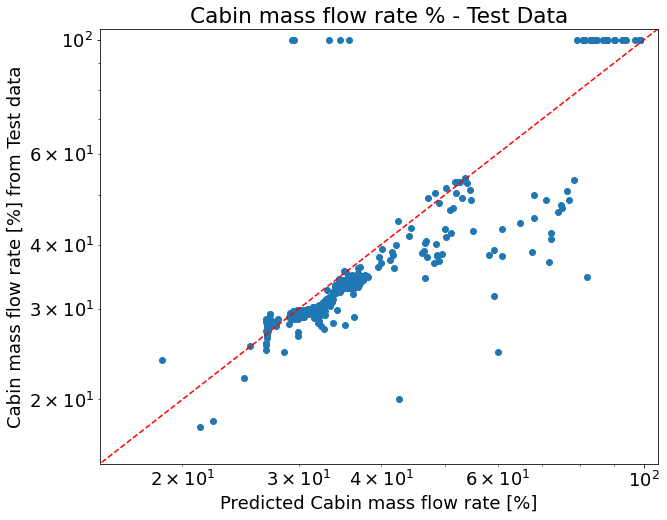

In [241]:
# Plot cabin
plt.rcParams['figure.figsize'] = [10, 8] # for square canvas
plt.rcParams.update({'font.size': 18})
plt.scatter(predicted_mCabin, actual_mCabin)
plt.loglog()
plt.title('Cabin mass flow rate % - Test Data')
plt.xlabel('Predicted Cabin mass flow rate [%]')
plt.ylabel('Cabin mass flow rate [%] from Test data')
x = np.linspace(1,1200)
y = np.linspace(1,1200)
plt.plot(x,y,linestyle='dashed', color='red', label = 'Best fit')
plt.xlim(xmax = 105, xmin = 15)
plt.ylim(ymax = 105, ymin = 15)
filename = path + SC + 'C_data_log.png' 
plt.savefig(filename, bbox_inches = 'tight')
plt.show()


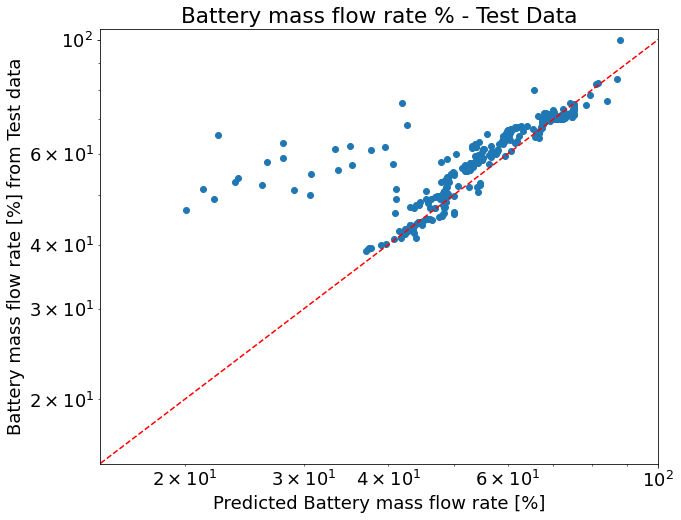

In [256]:
# Plot Battery
plt.rcParams['figure.figsize'] = [10, 8] # for square canvas
plt.rcParams.update({'font.size': 18})
plt.scatter(predicted_mBattery, actual_mBattery)
plt.loglog()
plt.title('Battery mass flow rate % - Test Data')
plt.xlabel('Predicted Battery mass flow rate [%]')
plt.ylabel('Battery mass flow rate [%] from Test data')
x = np.linspace(1,1200)
y = np.linspace(1,1200)
plt.plot(x,y,linestyle='dashed', color='red', label = 'Best fit')
plt.xlim(xmax = 100, xmin = 15)
plt.ylim(ymax = 105, ymin = 15)
filename = path + SC + 'B_data_log.png' 
plt.savefig(filename, bbox_inches = 'tight')
plt.show()

In [243]:
df_results= pd.DataFrame(data=(predicted_mCabin,actual_mCabin, predicted_mBattery,actual_mBattery)).transpose()

In [244]:
# Time array
dT = 30
Time = np.zeros(len(predicted_mBattery))
for i in range(len(predicted_mCabin)):
    Time[i] = i*dT/60 # min


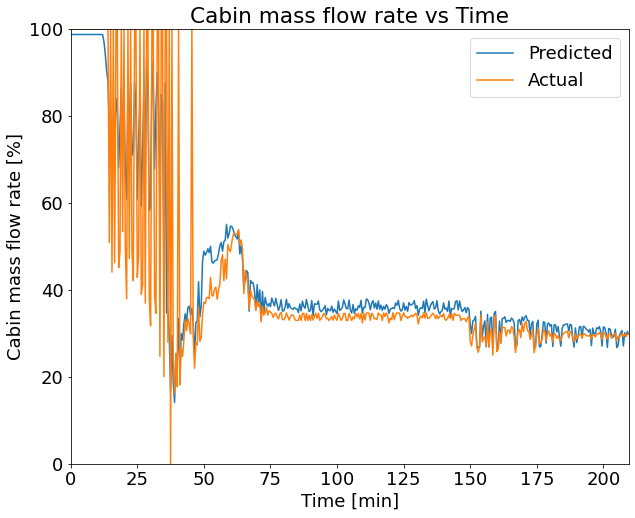

In [245]:
# Plot Cabin vs time
plt.rcParams['figure.figsize'] = [10, 8] # for square canvas
plt.rcParams.update({'font.size': 18})
plt.plot(Time, predicted_mCabin, label='Predicted')
plt.plot(Time, actual_mCabin, label='Actual')
plt.title('Cabin mass flow rate vs Time')
plt.xlabel('Time [min]')
plt.ylabel('Cabin mass flow rate [%]')
plt.xlim(xmax = np.max(Time), xmin = 0)
plt.ylim(ymax = 100, ymin = 0)
plt.legend()
filename = path + SC + 'C_mfr_time.png' 
plt.savefig(filename, bbox_inches = 'tight')
plt.show()

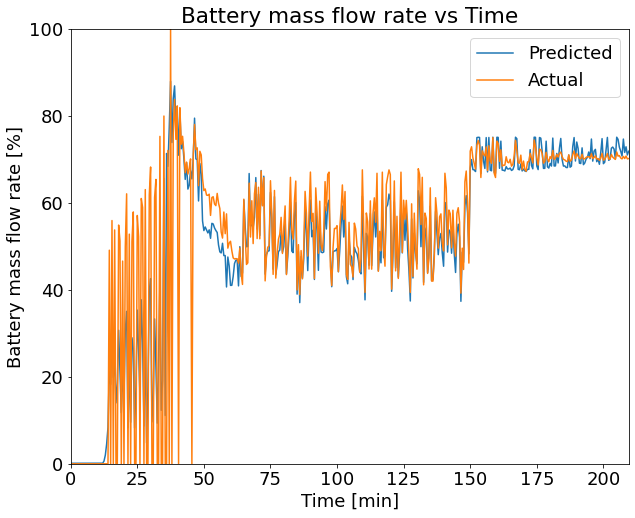

In [246]:
# Plot Battery vs time
plt.rcParams['figure.figsize'] = [10, 8] # for square canvas
plt.rcParams.update({'font.size': 18})
plt.plot(Time, predicted_mBattery, label = 'Predicted')
plt.plot(Time, actual_mBattery, label = 'Actual')
plt.title('Battery mass flow rate vs Time')
plt.xlabel('Time [min]')
plt.ylabel('Battery mass flow rate [%]')
plt.xlim(xmax = np.max(Time), xmin = 0)
plt.ylim(ymax = 100, ymin = 0)
plt.legend()
filename = path + SC + 'B_mfr_time.png' 
plt.savefig(filename, bbox_inches = 'tight')
plt.show()

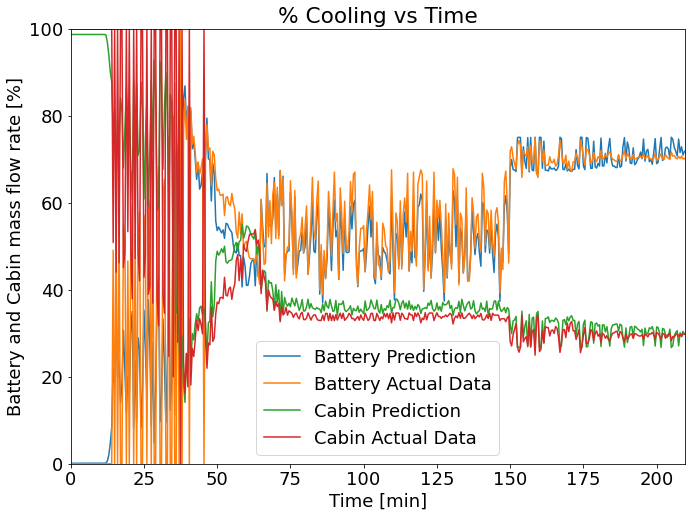

In [247]:
# Plot Battery vs time
plt.rcParams['figure.figsize'] = [11, 8] # for square canvas
plt.rcParams.update({'font.size': 18})
plt.plot(Time, predicted_mBattery, label = 'Battery Prediction')
plt.plot(Time, actual_mBattery, label = 'Battery Actual Data')
plt.plot(Time, predicted_mCabin, label = 'Cabin Prediction')
plt.plot(Time, actual_mCabin, label = 'Cabin Actual Data')
plt.title('% Cooling vs Time')
plt.xlabel('Time [min]')
plt.ylabel('Battery and Cabin mass flow rate [%]')
plt.xlim(xmax = np.max(Time), xmin = 0)
plt.ylim(ymax = 100, ymin = 0)
plt.legend()
filename = path + SC + 'BC_mfr_time.png' 
plt.savefig(filename, bbox_inches = 'tight')
plt.show()


In [248]:
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
import math 

df_results= pd.DataFrame(data=(predicted_mCabin,actual_mCabin)).transpose()

y_pred = np.array(df_results[:][0])
y_true = np.array(df_results[:][1])
               
mean_absolute_error(y_true, y_pred)


5.063904947341797

In [249]:

'Initialize: Heat Array, qarray'
qarray = np.zeros((len(df_inputs), 4))
pre_outputs = np.zeros((len(df_inputs),2))
act_outputs = np.copy(df_inputs[:,4:])

pre_df_inputs = df_inputs

T_cabin = pre_df_inputs[0][4]
T_bat = pre_df_inputs[0][5]

pre_outputs[0][0] = T_cabin
pre_outputs[0][1] = T_bat

pre_xDataNorm = np.zeros((1,6))

for i in range(len(pre_df_inputs)-1):
    
    '''Update Temperatures'''
    pre_df_inputs[i][4] = float(T_cabin)
    pre_df_inputs[i][5] = float(T_bat)
    
    # Calculate heat generation within the cabin and the battery
    #######################################################################################################################
    ##############################################  CABIN   HEAT  LOAD  ###################################################
    #######################################################################################################################

    '''Metabolic Load'''
    # From ISO 8996: Driver 85W/m2 and sitting passenger 55 W/m2
    # Estimation of surface area (Dubois Area)
    DuboisArea = 0.202*(WeightAVE**0.425)*HeightAVE**0.725

    #Metabolic Load
    Q_metabolic = DuboisArea*(DriverHR + pre_df_inputs[i][0]*SittingHR) * dT #W

    
    '''Ambient Load'''
    # Convective heat transfer coefficient
    h_int = 0.6 + 6.64*np.sqrt(V_int*1000/3600) # W/m2K
    h_out = 0.6 + 6.64*np.sqrt(pre_df_inputs[i][1]*1000/3600) # W/m2K

    # Overall heat transfer coefficient
    U_g = 1/(1/h_int + Thick_g/TConduc_g + 1/h_out)
    U_d = 1/(1/h_int + Thick_d/TConduc_d + 1/h_out)
    U_r = 1/(1/h_int + Thick_r/TConduc_r + 1/h_out)

    # To calculate the temperature of the surfaces Qcond = Qconv
    T_g = (h_out*pre_df_inputs[i][3]+TConduc_g*pre_df_inputs[i][4]/Thick_g)/(h_out+TConduc_g/Thick_g)
    T_d = (h_out*pre_df_inputs[i][3]+TConduc_d*pre_df_inputs[i][4]/Thick_d)/(h_out+TConduc_d/Thick_d)
    T_r = (h_out*pre_df_inputs[i][3]+TConduc_r*pre_df_inputs[i][4]/Thick_r)/(h_out+TConduc_r/Thick_r)

    #print(T_g,T_d,T_r)
    # The heat realeases to the cabin is
    Q_g = Area_g*U_g*(T_g-pre_df_inputs[i][4]) * dT
    Q_d = Area_d*U_d*(T_d-pre_df_inputs[i][4]) * dT
    Q_r = Area_r*U_r*(T_r-pre_df_inputs[i][4]) * dT

    #ambient load
    Q_ambient = Q_g + Q_d + Q_r 
        
    
    '''Ventilation Load'''
    # An easy way to calculate the fresh air thermal load is following the article "Electric Vehicle Battery Thermal
    # and Cabin Climate Management Based on Model Predictive Control"
    
    # As the CO2 linearly increases over time, a minimum flow of fresh air should be supplied into the cabin to maintain
    # the passengers confort
    
    Q_ventilation = 0.12*0.186*1000*(pre_df_inputs[i][3]-pre_df_inputs[i][4]) * dT
    
    
    '''Radiation load'''
    # Radiation should be in units [W/m2] not [W]

    # Direct = Part of the incident radiation that directly strikes a surface 
    # of the vehicle
    Q_direct = 1000 * dT # W

    # Diffuse radiation is the part of solar radiation which results from indirect
    # radiation of daylight on the surface
    # This value can be modified...
    Q_diffuse = 190 * dT # W

    # Reflected radiation refers to the part of radiation heat gain that is reflected 
    # from the ground and strikes the body surface of the vehicle. 
    # This value can be modified...
    Q_reflected = 0 * dT # W

    # Radiation Load
    Q_radiation = Q_direct + Q_diffuse + Q_reflected


    '''Total Cabin Heat'''
    Q_cabin = Q_metabolic + Q_ambient + Q_ventilation + Q_radiation
        
    qarray[i][0]=Q_cabin

    
    #######################################################################################################################
    ##############################################  BATTERY HEAT GAIN   ###################################################
    #######################################################################################################################
    
    slope = np.arctan(pre_df_inputs[i][2]/100)
    slope_d = slope*360/(2*np.pi)
    mass_veh_total = mass_veh + pre_df_inputs[i][0]*WeightAVE


    ''' Heat Gain due to driving'''
    # Forces on vehicle
    f_drag = 0.5*rho_amb*(pre_df_inputs[i][1]/3.6)**2*cd*area_front
    f_rolling = crr*mass_veh_total*g*np.cos(slope)
    f_gravity = mass_veh_total*g*np.sin(slope)
    f_total = f_drag+f_rolling+f_gravity

    # Power of vehicle
    p_drive = f_total*(pre_df_inputs[i][1]/3.6)*10**-3          #kW

    # Heat gain of battery, due to driving
    Q_bat_drive = p_drive*(1-eta_bat)*1000*dT          # [W]
    
    
    '''Heat Gain due to compressor power'''
    # AC is always on
    W_comp = 4                     # [kW]  (compressor power is constant for now...)

    Q_bat_comp = (1 - eta_comp)*W_comp*1000*dT
    
    '''Auxiliary Power - System Electronics'''
    # Except for the steering power, air conditioning and window defroster, the rest auxiliary consumption is covered by 
    # the auxiliary battery. As depicted in https://onlinelibrary.wiley.com/doi/epdf/10.1002/er.5700 only the driving control
    # and the energy management system are taken into consideration (Total = 300W)
    p_aux = 500 # W
    Q_bat_aux = (1 - eta_bat)*p_aux*dT
    
    '''Total Battery Heat'''
    Q_bat = Q_bat_drive + Q_bat_comp + Q_bat_aux
        
    qarray[i][1] = Q_bat

    ##########################################################################################################################
    'Evaporator, Condenser conditions'
    T_ref_evap = 4                        #[C], 4 deg above freezing     (should this value be static?)
    T_ref_cond = pre_df_inputs[i][3] + 10        #[C], 10 deg above ambient temperature
    
    # Find latent heat from evaporator temperature
    hfg_ref_cool = (hfg_ref[int(hfg_ref[np.where(hfg_ref == round(T_ref_evap,0))])][3])*Ref_quality*1000 # [J/kg]
    # calculate the max mass flow rate
    Mass_max_cap = (AC_max_cap / hfg_ref_cool)/dT
    
    # Normalize Data inputs
    pre_xDataNorm[0][0] = pre_df_inputs[i][0]/xDataMedian[0]
    pre_xDataNorm[0][1] = pre_df_inputs[i][1]/xDataMedian[1]
    pre_xDataNorm[0][2] = pre_df_inputs[i][2]/xDataMedian[2]
    pre_xDataNorm[0][3] = pre_df_inputs[i][3]/xDataMedian[3]
    pre_xDataNorm[0][4] = pre_df_inputs[i][4]/xDataMedian[4]
    pre_xDataNorm[0][5] = pre_df_inputs[i][5]/xDataMedian[5]


    pre_mCabin = recon_model.predict(pre_xDataNorm)[0][0]*100
    act_mCabin = df_outputs[i][0]
    pre_mBattery = recon_model.predict(pre_xDataNorm)[0][1]*100
    act_mBattery = df_outputs[i][1]

    
    # Calculate heat to disipate - Prediction ML
    pre_mfr_cabin = pre_mCabin*Mass_max_cap/100
    qarray[i][2] = -pre_mfr_cabin*dT*hfg_ref_cool
    pre_mfr_bat = pre_mBattery*Mass_max_cap/100
    qarray[i][3] = -pre_mfr_bat*dT*hfg_ref_cool
        

    'Update Temperatures for Next Time Step'
    # Cabin Temperature ML
    pre_deltaT_cabin = ((qarray[i][0] + qarray[i][2]) / (rho_cabin * V_cabin * cp_air + DTM))
    pre_outputs[i+1][0] = pre_df_inputs[i][4] + pre_deltaT_cabin
    T_cabin = pre_outputs[i+1][0]
    # Battery Temperature ML
    pre_deltaT_bat = (qarray[i][1] + qarray[i][3]) / (mass_bat * cp_bat)
    pre_outputs[i+1][1] = pre_df_inputs[i][5] + pre_deltaT_bat
    T_bat = pre_outputs[i+1][1]
        
    

In [250]:
# TEMPERATURE

actual_TCabin = act_outputs[:,0]
actual_TBattery = act_outputs[:,1]
predicted_TCabin = pre_outputs[:,0]
predicted_TBattery = pre_outputs[:,1]

import matplotlib.pyplot as plt
import math
from scipy.stats import pearsonr

# Calculate the Pearson correlation coefficient - used to summarize the strength of the linear 
# relationship between two data samples.
corr_cab, _ = pearsonr(actual_TCabin, predicted_TCabin)
corr_bat, _ = pearsonr(actual_TBattery, predicted_TBattery)
print('Pearsons correlation: %.3f' % corr_cab)
print('Pearsons correlation: %.3f' % corr_bat)

Pearsons correlation: 1.000
Pearsons correlation: 0.998


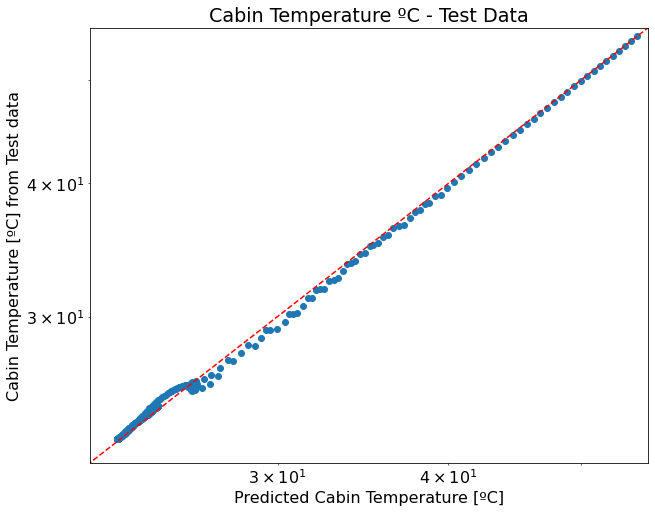

In [251]:
# Plot cabin
plt.rcParams['figure.figsize'] = [10, 8] # for square canvas
plt.rcParams.update({'font.size': 16})
plt.scatter(predicted_TCabin, actual_TCabin)
plt.loglog()
plt.title('Cabin Temperature ºC - Test Data')
plt.xlabel('Predicted Cabin Temperature [ºC]')
plt.ylabel('Cabin Temperature [ºC] from Test data')
x = np.linspace(1,1200)
y = np.linspace(1,1200)
plt.plot(x,y,linestyle='dashed', color='red', label = 'Best fit')
plt.xlim(xmax = max(max(predicted_TCabin), max(actual_TCabin))+1 , xmin =min(min(predicted_TCabin), min(actual_TCabin))-1)
plt.ylim(ymax = max(max(predicted_TCabin), max(actual_TCabin))+1, ymin = min(min(predicted_TCabin), min(actual_TCabin))-1)
filename = path + SC + 'C_ds_log.png' 
plt.savefig(filename, bbox_inches = 'tight')
plt.show()

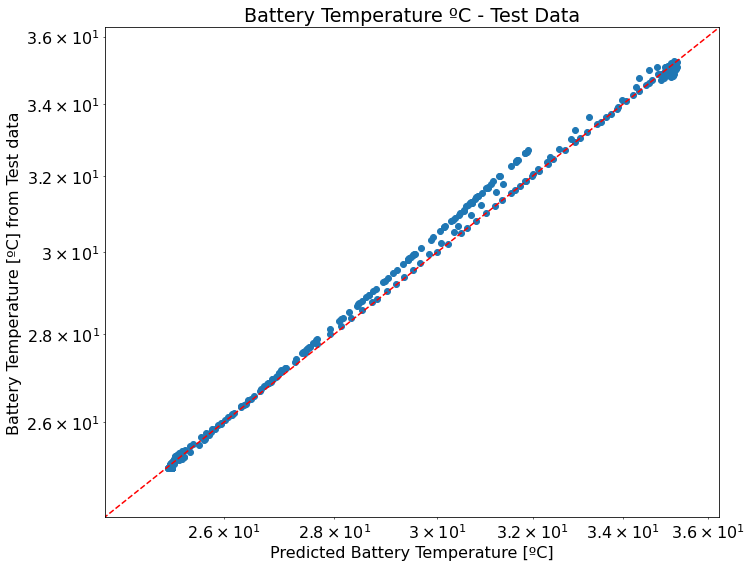

In [252]:
# Plot Battery
plt.rcParams['figure.figsize'] = [11,9] # for square canvas
plt.rcParams.update({'font.size': 16})
plt.scatter(predicted_TBattery, actual_TBattery)
plt.loglog()
plt.title('Battery Temperature ºC - Test Data')
plt.xlabel('Predicted Battery Temperature [ºC]')
plt.ylabel('Battery Temperature [ºC] from Test data')
x = np.linspace(1,1200)
y = np.linspace(1,1200)
plt.plot(x,y,linestyle='dashed', color='red', label = 'Best fit')
plt.xlim(xmax = max(max(predicted_TBattery), max(actual_TBattery))+1 , xmin =min(min(predicted_TBattery), min(actual_TBattery))-1)
plt.ylim(ymax = max(max(predicted_TBattery), max(actual_TBattery))+1, ymin = min(min(predicted_TBattery), min(actual_TBattery))-1)
#plt.xlim(xmax = 37  , xmin =24)
#plt.ylim(ymax = 37  , ymin =24)
filename = path + SC + 'B_ds_log.png' 
plt.savefig(filename, bbox_inches = 'tight')
plt.show()

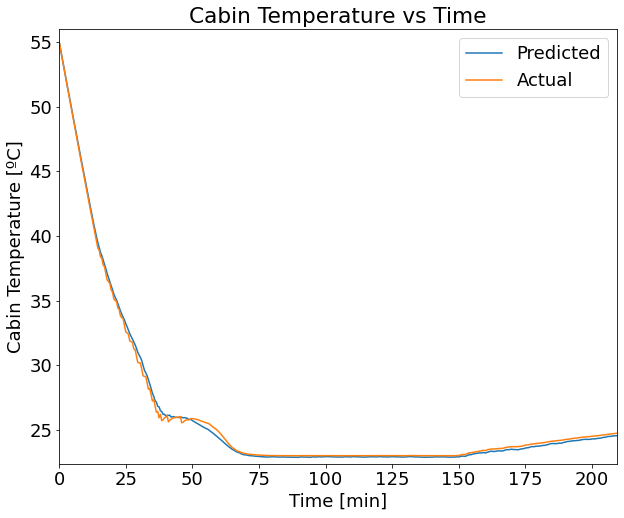

In [253]:
# Plot Cabin vs time
plt.rcParams['figure.figsize'] = [10, 8] # for square canvas
plt.rcParams.update({'font.size': 18})
plt.plot(Time, predicted_TCabin, label = 'Predicted')
plt.plot(Time, actual_TCabin, label = 'Actual')
plt.title('Cabin Temperature vs Time')
plt.xlabel('Time [min]')
plt.ylabel('Cabin Temperature [ºC]')
plt.xlim(xmax = np.max(Time), xmin = 0)
plt.ylim(ymax = np.max(predicted_TCabin)+1, ymin = np.min(predicted_TCabin)-0.5)
plt.legend()
filename = path + SC + 'C_T_time.png' 
plt.savefig(filename, bbox_inches = 'tight')
plt.show()

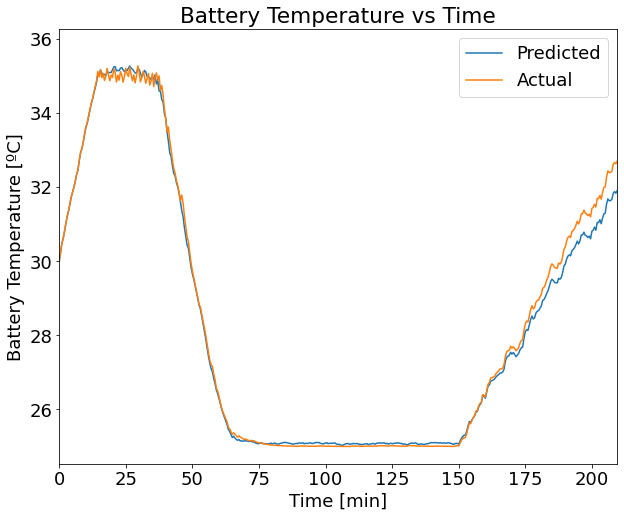

In [254]:
# Plot Battery vs time
plt.rcParams['figure.figsize'] = [10, 8] # for square canvas
plt.rcParams.update({'font.size': 18})
plt.plot(Time, predicted_TBattery, label = 'Predicted')
plt.plot(Time, actual_TBattery, label = 'Actual')
plt.title('Battery Temperature vs Time')
plt.xlabel('Time [min]')
plt.ylabel('Battery Temperature [ºC]')
plt.xlim(xmax = np.max(Time), xmin = 0)
plt.ylim(ymax = np.max(predicted_TBattery)+1, ymin =np.min(predicted_TBattery)-0.5)
plt.legend()
filename = path + SC + 'B_T_time.png' 
plt.savefig(filename)
plt.show()

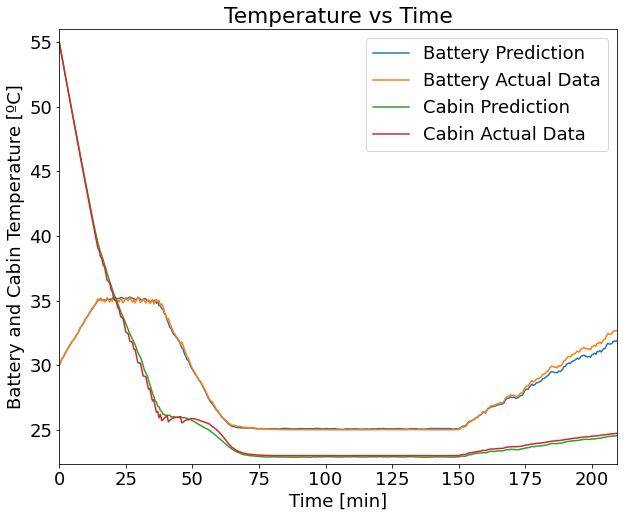

In [255]:
# Plot Battery vs time
plt.rcParams['figure.figsize'] = [10, 8] # for square canvas
plt.rcParams.update({'font.size': 18})
plt.plot(Time, predicted_TBattery, label = 'Battery Prediction')
plt.plot(Time, actual_TBattery, label = 'Battery Actual Data')
plt.plot(Time, predicted_TCabin, label = 'Cabin Prediction')
plt.plot(Time, actual_TCabin, label = 'Cabin Actual Data')
plt.title('Temperature vs Time')
plt.xlabel('Time [min]')
plt.ylabel('Battery and Cabin Temperature [ºC]')
plt.xlim(xmax = np.max(Time), xmin = 0)
plt.ylim(ymax = max(max(predicted_TBattery), max(predicted_TCabin))+1, ymin = min(min(predicted_TBattery), min(predicted_TCabin))-0.5)
plt.legend()
filename = path + SC + 'BC_T_time.png' 
plt.savefig(filename)
plt.show()